# HW5, DATSCI W261
Team: Kuan Lin, Alejandro J. Rojas, Ricardo Barrera<br/>
Emails: kuanlin@ischool.berkeley.edu, ale@ischool.berkeley.edu, ricardofrank@ischool.berkeley.edu<br/>
Time of Initial Submission: 8:00 AM PST, Thursday, Feb 18, 2016<br/>
W261-1, Spring 2016 Week 6 Homework

# HW 5.0
What is a data warehouse? What is a Star schema? When is it used?

Data warehouse is an integrated database often used to store both current and historical data for the purpose of reporting and analytics.

A Star Schema is a special case of snow-flake schema where there has a fact table at the center surrounded by dimension tables that are referenced to the fact table with foriegn keys.  The star schema has a relaxed normalization rule compared to other types of schemas and therefore can be easier to implement and query for small-scale information systems.

# HW 5.1
In the database world What is 3NF? Does machine learning use data in 3NF? If so why? 
In what form does ML consume data?
Why would one use log files that are denormalized?

3NF (3rd normal form) must first satisfy 1NF and 2NF, which includes:
* Eliminate repeating groups in individual tables.
* Create a separate table for each set of related data.
* Identify each set of related data with a primary key
* no non-prime attribute is dependent on any proper subset of any candidate key of the table

In addition, the schema must also satisfy:
* Every non-prime attribute of a table is non-transitively dependent on every key of a table

In instance-based (such as K-mean) and supervised ML algorithms, the algorithm must be able to access all attributes (that made through feature selections) on each data point, and therefore many ML algorithms need a dense matrix of data rather than a normaled form.  Use a denormalized log file allows ML algorithm to parse out all required attributes of the data which satisfies the aforementioned requiredments.

# HW 5.2
Using MRJob, implement a hashside join (memory-backed map-side) for left, 
right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)

Justify which table you chose as the Left table in this hashside join.

Please report the number of rows resulting from:

(1) Left joining Table Left with Table Right<br/>
(2) Right joining Table Left with Table Right<br/>
(3) Inner joining Table Left with Table Right<br/>

Answer: Since the url table is much smaller, it is better to store the url table in memory as a hashtable and perform the join as the right table.  Therefore the better option is to use the visit-info table on the left, and use the url-table as the memory-backed hash table on the right.  Also, it is possible that the url is not documented, and therefore option 1 (left join) is a prefered solution so that we don't have to drop visit data in the case of unmatched url.

In [2]:
# first, reproduced the needed tables from hw4

# make the reformated table for visit info:
source_file = 'anonymous-msweb.data'
output_file = 'reformated_webdata.csv'

writer = open(output_file, 'w')
current_visitor = None
for line in open(source_file, 'r'):
    line = line.strip()
    if line == '' or (not line.startswith("C,") and not line.startswith("V")): continue
    lineArr = line.split(',')
    if lineArr[0] == 'C':
        current_visitor = lineArr[2]
    elif current_visitor != None:
        writer.write(line + ',C,' + current_visitor + '\n')
writer.close()

# make the url table:
# need to first extract out the urls, will be used to lookup url in reducer
import csv
source_file = 'anonymous-msweb.data'
output_file = 'url_data.csv'
writer = open(output_file, 'w')

for line in open(source_file, 'r'):
    line = line.strip()
    if line == '':
        continue
    if line.startswith('A,'):
        lineArr = list(csv.reader(line.splitlines(), delimiter=',', quotechar='"'))[0]
        writer.write(','.join([lineArr[1], lineArr[4].replace('/', '')]) + '\n')
writer.close()

In [3]:
%%writefile top_visitor.py
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep

# option1: Left Join

class TopVisitor(MRJob):
    
    OUTPUT_PROTOCOL = RawValueProtocol
    
    def steps(self):
        # two step processes: firs step to calculate visit counts per user and page combination
        # second step to rank user by their visit counts within each page
        return [
            MRStep(mapper=self.process_visits, reducer=self.aggregate_visits),
            MRStep(reducer_init=self.load_url_info, reducer=self.find_most_freq_visitor)
        ]
    
    def process_visits(self, _, line):
        # emiting visit counts per user and page combination
        lineArr = line.strip().split(',')
        page_id = lineArr[1]
        visit_counts = int(lineArr[2])
        visitor_id = lineArr[4]
        yield (page_id, visitor_id), visit_counts 
        
    def aggregate_visits(self, page_visitor_id, visit_counts):
        # calculate how many visits from each visitor on the particular page
        yield page_visitor_id[0], (page_visitor_id[1], sum(visit_counts))
        
    def load_url_info(self):
        # loading up URL dictionary to used for lookup in reducer
        self.URLs = {}
        for line in open('url_data.csv', 'r'):
            lineArr = line.strip().split(',')
            self.URLs[lineArr[0]] = lineArr[1]
            
    def find_most_freq_visitor(self, page_id, visitor_data):
        # find the most frequent visotor for each page.
        max_visitor = None
        max_visits = 0
        for visitor_id, visit_counts in visitor_data:
            if visit_counts > max_visits:
                max_visitor = visitor_id
                max_visits = visit_counts
        page_url = 'UNKN'
        # lookup URL
        if page_id in self.URLs:
            page_url = self.URLs[page_id]
        
        yield None, '\t'.join([page_url, page_id, max_visitor])
    
if __name__ == '__main__':
    TopVisitor.run()

Writing top_visitor.py


In [5]:
!python top_visitor.py reformated_webdata.csv --file url_data.csv > 5_2_left_join.txt

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\top_visitor.kuanlin.20160214.233953.231000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\top_visitor.kuanlin.20160214.233953.231000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\top_visitor.kuanlin.20160214.233953.231000\step-0-mapper-sorted
> sort 'c:\temp\top_visitor.kuanlin.20160214.233953.231000\step-0-mapper_part-00000'
writing to c:\temp\top_visitor.kuanlin.20160214.233953.231000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\top_visitor.kuanlin.20160214.233953.231000\step-1-mapper_part-00000
Counters from step 2:
  (no counters found)
writing to c

In [10]:
%%writefile top_visitor.py
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep

# option2: Right Join

class TopVisitor(MRJob):
    
    OUTPUT_PROTOCOL = RawValueProtocol
    
    def steps(self):
        # two step processes: firs step to calculate visit counts per user and page combination
        # second step to rank user by their visit counts within each page
        return [
            MRStep(mapper=self.process_visits, reducer=self.aggregate_visits),
            MRStep(reducer_init=self.load_url_info, reducer=self.find_most_freq_visitor, reducer_final=self.output_info)
        ]
    
    def process_visits(self, _, line):
        # emiting visit counts per user and page combination
        lineArr = line.strip().split(',')
        page_id = lineArr[1]
        visit_counts = int(lineArr[2])
        visitor_id = lineArr[4]
        yield (page_id, visitor_id), visit_counts 
        
    def aggregate_visits(self, page_visitor_id, visit_counts):
        # calculate how many visits from each visitor on the particular page
        yield page_visitor_id[0], (page_visitor_id[1], sum(visit_counts))
        
    def load_url_info(self):
        # loading up URL dictionary to used for lookup in reducer
        self.URLs = {}
        self.visit_data = {}
        for line in open('url_data.csv', 'r'):
            lineArr = line.strip().split(',')
            self.URLs[lineArr[0]] = lineArr[1]
            
    def find_most_freq_visitor(self, page_id, visitor_data):
        # find the most frequent visotor for each page.
        max_visitor = None
        max_visits = 0
        for visitor_id, visit_counts in visitor_data:
            if visit_counts > max_visits:
                max_visitor = visitor_id
                max_visits = visit_counts
        self.visit_data[page_id] = max_visitor

    def output_info(self):
        writer = open('5_2_right_join.txt', 'w')
        for page_id in self.URLs:
            if page_id in self.visit_data:
                writer.write('\t'.join([self.URLs[page_id], page_id, self.visit_data[page_id]]) + '\n')
            else:
                writer.write('\t'.join([self.URLs[page_id], page_id, 'no_visitor_data']) + '\n')
        writer.close()
    
if __name__ == '__main__':
    TopVisitor.run()

Overwriting top_visitor.py


In [11]:
# right-side join
!python top_visitor.py reformated_webdata.csv --file url_data.csv

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\top_visitor.kuanlin.20160214.235335.585000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\top_visitor.kuanlin.20160214.235335.585000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\top_visitor.kuanlin.20160214.235335.585000\step-0-mapper-sorted
> sort 'c:\temp\top_visitor.kuanlin.20160214.235335.585000\step-0-mapper_part-00000'
writing to c:\temp\top_visitor.kuanlin.20160214.235335.585000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\top_visitor.kuanlin.20160214.235335.585000\step-1-mapper_part-00000
Counters from step 2:
  (no counters found)
writing to c

In [12]:
%%writefile top_visitor.py
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep

# option3: Inner Join

class TopVisitor(MRJob):
    
    OUTPUT_PROTOCOL = RawValueProtocol
    
    def steps(self):
        # two step processes: firs step to calculate visit counts per user and page combination
        # second step to rank user by their visit counts within each page
        return [
            MRStep(mapper=self.process_visits, reducer=self.aggregate_visits),
            MRStep(reducer_init=self.load_url_info, reducer=self.find_most_freq_visitor)
        ]
    
    def process_visits(self, _, line):
        # emiting visit counts per user and page combination
        lineArr = line.strip().split(',')
        page_id = lineArr[1]
        visit_counts = int(lineArr[2])
        visitor_id = lineArr[4]
        yield (page_id, visitor_id), visit_counts 
        
    def aggregate_visits(self, page_visitor_id, visit_counts):
        # calculate how many visits from each visitor on the particular page
        yield page_visitor_id[0], (page_visitor_id[1], sum(visit_counts))
        
    def load_url_info(self):
        # loading up URL dictionary to used for lookup in reducer
        self.URLs = {}
        for line in open('url_data.csv', 'r'):
            lineArr = line.strip().split(',')
            self.URLs[lineArr[0]] = lineArr[1]
            
    def find_most_freq_visitor(self, page_id, visitor_data):
        # find the most frequent visotor for each page.
        max_visitor = None
        max_visits = 0
        for visitor_id, visit_counts in visitor_data:
            if visit_counts > max_visits:
                max_visitor = visitor_id
                max_visits = visit_counts
        page_url = 'UNKN'
        # lookup URL
        if page_id in self.URLs:
            page_url = self.URLs[page_id]
        
        if page_url != 'UNKN':
            yield None, '\t'.join([page_url, page_id, max_visitor])
    
if __name__ == '__main__':
    TopVisitor.run()

Overwriting top_visitor.py


In [13]:
!python top_visitor.py reformated_webdata.csv --file url_data.csv > 5_2_inner_join.txt

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\top_visitor.kuanlin.20160214.235537.554000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\top_visitor.kuanlin.20160214.235537.554000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\top_visitor.kuanlin.20160214.235537.554000\step-0-mapper-sorted
> sort 'c:\temp\top_visitor.kuanlin.20160214.235537.554000\step-0-mapper_part-00000'
writing to c:\temp\top_visitor.kuanlin.20160214.235537.554000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\top_visitor.kuanlin.20160214.235537.554000\step-1-mapper_part-00000
Counters from step 2:
  (no counters found)
writing to c

In [15]:
# report number of rows in the results:
print "--------------------------------------"
print "Number of rows in left join results:"
print sum(1 for line in open('5_2_left_join.txt', 'r'))

print "--------------------------------------"
print "Number of rows in right join results:"
print sum(1 for line in open('5_2_right_join.txt', 'r'))

print "--------------------------------------"
print "Number of rows in inner join results:"
print sum(1 for line in open('5_2_inner_join.txt', 'r'))

--------------------------------------
Number of rows in left join results:
285
--------------------------------------
Number of rows in right join results:
294
--------------------------------------
Number of rows in inner join results:
285


# HW 5.3 For the remainder of this assignment you will work with two datasets:
### 1: unit/systems test data set: SYSTEMS TEST DATASET
Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

<pre>
DocA {X:20, Y:30, Z:5}
DocB {X:100, Y:20}
DocC {M:5, N:20, Z:5}
</pre>

### 2: A large subset of the Google n-grams dataset

https://aws.amazon.com/datasets/google-books-ngrams/

which we have placed in a bucket/folder on Dropbox on s3:

   https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=0 

   s3://filtered-5grams/

For each HW 5.3 -5.5 Please unit test and system test your code with with SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations. Then show the results you get with you system.
Final show your results on the Google n-grams dataset


In particular, this bucket contains (~200) files (10Meg each) in the format:

	(ngram) \t (count) \t (pages_count) \t (books_count)

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (please use the count information), i.e., unigrams
- 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

OPTIONAL Question:
- Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

In [18]:
%%writefile longest_5gram.py
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep

# Q1: looking for longest 5-gram (number of characters)

class longest_5gram(MRJob):
    
    def mapper(self, _, line):
        ngram = line.strip().split('\t')[0]
        # stream everyghint into one reducer
        yield None, ngram
        
    def reducer(self, _, ngram):
        # since there is only one reducer (only one key), store the logest ngram in memory
        self.logest_ngram = None
        for ng in ngram:
            if self.logest_ngram == None or len(ng) > len(self.logest_ngram):
                self.logest_ngram = ng
        # emit the finding
        yield self.logest_ngram, len(self.logest_ngram)

if __name__ == '__main__':
    longest_5gram.run()

Writing longest_5gram.py


In [19]:
# this should give us the logest ngram
!python longest_5gram.py filtered-5Grams

"distinct categories of posttransplantation lymphoproliferative"	62


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\longest_5gram.kuanlin.20160215.054429.573000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\longest_5gram.kuanlin.20160215.054429.573000\step-0-mapper_part-00000
writing to c:\temp\longest_5gram.kuanlin.20160215.054429.573000\step-0-mapper_part-00001
Counters from step 1:
  (no counters found)
writing to c:\temp\longest_5gram.kuanlin.20160215.054429.573000\step-0-mapper-sorted
> sort 'c:\temp\longest_5gram.kuanlin.20160215.054429.573000\step-0-mapper_part-00000' 'c:\temp\longest_5gram.kuanlin.20160215.054429.573000\step-0-mapper_part-00001'
Piping files into sort for Windows compatibility
> sort
writing to c:\temp\longest_5gram.kuanlin.2

In [20]:
%%writefile top_vocabs.py
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep

# this script is to find the top 1000 vocabs words

class top_vocabs(MRJob):
    # use raw value protocol to get inversion done easier
    #INPUT_PROTOCOL = RawValueProtocol
    #INTERNAL_PROTOCOL = RawValueProtocol
    #OUTPUT_PROTOCOL = RawValueProtocol
    
    # step1 do word counts
    # step2 get the top 1000 vocabs by counts
    def steps(self):
        return [
            MRStep(mapper=self.wordCountsMapper, reducer=self.wordCountsReducer),
            MRStep(reducer_init=self.rankWords_init, reducer=self.getTopVocabs,
                  jobconf={
                    'stream.num.map.output.key.fields': 2,
                    'mapreduce.partition.keypartitioner.options': '-k1,1',
                    'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                    'mapred.text.key.comparator.options': "-k2,2nr",
                    'mapred.reduce.tasks': 1
                })
        ]      

    def wordCountsMapper(self, _, line):
        lineArr = line.strip().split('\t')
        ngram_count = int(lineArr[1])
        for word in lineArr[0].split(' '):
            # each word appear n times as the ngram count
            yield word.lower() , ngram_count
            
    def wordCountsReducer(self, word, counts):
        # summing up counts for each word
        yield word, sum(counts)
        
    def rankWords_init(self):
        self.vocab = set()
        # grab the top 1000 words as vocab
        self.vocab_size = 1000
        
    def getTopVocabs(self, word, count):
        if len(self.vocab) < self.vocab_size:
            self.vocab.add(word)
            yield word, max(count)

if __name__ == '__main__':
    top_vocabs.run()

Overwriting top_vocabs.py


In [ ]:
# look for unigram frequencies
!python top_vocabs.py filtered-5Grams

In [23]:
print "top 10 most frequent words"
num = 0
for line in open('vocabs_full.txt', 'r'):
    if num < 10: num += 1; print line.strip()

top 10 most frequent words
"the"	5490815394
"of"	3698583299
"to"	2227866570
"in"	1421312776
"a"	1361123022
"and"	1149577477
"that"	802921147
"is"	758328796
"be"	688707130
"as"	492170314


In [6]:
%%writefile word_density.py
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep

# Q3: calculating word densities

class word_density(MRJob):
    
    def mapper(self, _, line):
        (ngram, count, page_count, book_count) = line.strip().split('\t')
        # emit grouped by words
        for word in ngram.split(' '):
            yield word.strip().lower(), (int(count), int(page_count))
        
    def reducer(self, word, count_data):
        count = 0
        page_count = 0
        # aggregate counts
        for data in count_data:
            count += data[0]
            page_count += data[1]
        yield word, float(count)/float(page_count)

if __name__ == '__main__':
    word_density.run()

Overwriting word_density.py


In [7]:
!python word_density.py filtered-5Grams > word_density.txt

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\word_density.kuanlin.20160215.061325.840000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\word_density.kuanlin.20160215.061325.840000\step-0-mapper_part-00000
writing to c:\temp\word_density.kuanlin.20160215.061325.840000\step-0-mapper_part-00001
Counters from step 1:
  (no counters found)
writing to c:\temp\word_density.kuanlin.20160215.061325.840000\step-0-mapper-sorted
> sort 'c:\temp\word_density.kuanlin.20160215.061325.840000\step-0-mapper_part-00000' 'c:\temp\word_density.kuanlin.20160215.061325.840000\step-0-mapper_part-00001'
Piping files into sort for Windows compatibility
> sort
writing to c:\temp\word_density.kuanlin.20160215

In [11]:
word_densities = sorted([(float(line.strip().split('\t')[1]), line.strip().split('\t')[0].replace('"', '')) for line in open('word_density.txt', 'r')], reverse=True)
print "20 most densely appearing words:"
for w in word_densities[:20]:
    print "%s: %s" %w
print
print "20 least densely appearing words:"
for w in word_densities[len(word_densities)-20:]:
    print "%s: %s" %w

20 most densely appearing words:
3.57692307692: pfeffermann
3.57692307692: madarassy
3.52764423077: cs
2.81918819188: irc
1.98152424942: chlorinated
1.88: electrocardiograph
1.84325396825: recalcitrant
1.81181485993: rectory
1.80952380952: andrea
1.80710172745: bailee
1.77213240955: unclean
1.75384615385: tangibility
1.73913043478: nqong
1.71653543307: almagro
1.71428571429: seacoast
1.67346938776: bartas
1.6043956044: tra
1.60135135135: compellable
1.56818181818: echinoidea
1.55555555556: demokratischen

20 least densely appearing words:
1.0: abd
1.0: abc
1.0: abbotshall
1.0: abbotsford
1.0: abbassides
1.0: abbaside
1.0: abbasid
1.0: abbacies
1.0: abating
1.0: abated
1.0: abate
1.0: abashless
1.0: abashed
1.0: abased
1.0: abandons
1.0: abandoning
1.0: aback
1.0: aazaz
1.0: aar
1.0: aachen


In [14]:
%%writefile ngram_histogram.py
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep

# Q4: make ngram char length histogram

class ngram_histogram(MRJob):
    # don't need key to make histogram
    OUTPUT_PROTOCOL = RawValueProtocol
    
    def mapper(self, _, line):
        ngram = line.strip().split('\t')[0]
        # just need to print out ngram char length.  no need for reducer
        yield None, len(ngram)

if __name__ == '__main__':
    ngram_histogram.run()

Overwriting ngram_histogram.py


In [15]:
!python ngram_histogram.py filtered-5Grams > char_length_hist_data.txt

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory c:\temp\ngram_histogram.kuanlin.20160215.063138.378000

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to c:\temp\ngram_histogram.kuanlin.20160215.063138.378000\step-0-mapper_part-00000
writing to c:\temp\ngram_histogram.kuanlin.20160215.063138.378000\step-0-mapper_part-00001
Counters from step 1:
  (no counters found)
Moving c:\temp\ngram_histogram.kuanlin.20160215.063138.378000\step-0-mapper_part-00000 -> c:\temp\ngram_histogram.kuanlin.20160215.063138.378000\output\part-00000
Moving c:\temp\ngram_histogram.kuanlin.20160215.063138.378000\step-0-mapper_part-00001 -> c:\temp\ngram_histogram.kuanlin.20160215.063138.378000\output\part-00001
Streaming final ou

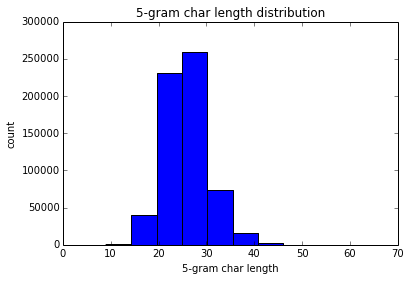

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# make the char-length distribution histogram

plt.hist([int(l.strip()) for l in open('char_length_hist_data.txt', 'r')])
plt.title("5-gram char length distribution")
plt.xlabel("5-gram char length")
plt.ylabel("count")
plt.show()


# HW 5.4  (over 2Gig of Data)
In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

(1) Build stripes of word co-ocurrence for the top 10,000 using the words ranked from 9001,-10,000 as a basis
most frequently appearing words across the entire set of 5-grams,
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).

(2) Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

==Design notes for (1)==
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

==Design notes for (2)==
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation
...

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

In [17]:
# configuration for running MRJob on EMR
import os

aws_id = os.environ['AWSAccessKeyId']
aws_key = os.environ['AWSSecretKey']

writer = open('mrjob_emr.conf', 'w')
writer.write(
"""runners:
  emr:
    aws_access_key_id: %s
    aws_region: us-east-1
    ec2_instance_type: m1.medium
    ec2_master_instance_type: m1.medium
    num_ec2_instances: 4
    aws_secret_access_key: %s"""%(aws_id, aws_key)
)
writer.close()

In [6]:
%%writefile top_vocabs.py
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep

# this script is to find the top 1000 vocabs words

class top_vocabs(MRJob):
    # use raw value protocol to get inversion done easier
    #INPUT_PROTOCOL = RawValueProtocol
    #INTERNAL_PROTOCOL = RawValueProtocol
    #OUTPUT_PROTOCOL = RawValueProtocol
    
    # step1 do word counts
    # step2 get the top 1000 vocabs by counts
    def steps(self):
        return [
            MRStep(mapper=self.wordCountsMapper, reducer=self.wordCountsReducer),
            MRStep(reducer_init=self.rankWords_init, reducer=self.getTopVocabs,
                  jobconf={
                    'stream.num.map.output.key.fields': 2,
                    'mapreduce.partition.keypartitioner.options': '-k1,1',
                    'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                    'mapred.text.key.comparator.options': "-k2,2nr",
                    'mapred.reduce.tasks': 1
                })
        ]      

    def wordCountsMapper(self, _, line):
        lineArr = line.strip().split('\t')
        ngram_count = int(lineArr[1])
        for word in lineArr[0].split(' '):
            # each word appear n times as the ngram count
            yield word.lower() , ngram_count
            
    def wordCountsReducer(self, word, counts):
        # summing up counts for each word
        yield word, sum(counts)
        
    def rankWords_init(self):
        self.vocab = set()
        # grab the top 1000 words as vocab
        self.vocab_size = 1000
        
    def getTopVocabs(self, word, count):
        if len(self.vocab) < self.vocab_size:
            self.vocab.add(word)
            yield word, max(count)

if __name__ == '__main__':
    top_vocabs.run()

Writing top_vocabs.py


In [ ]:
!python top_vocabs.py -r emr -c mrjob_emr.conf s3://filtered-5grams/ --output-dir=s3://lin.berkeley.mids/w261/hw5/vocab/ --no-output

In [20]:
%%writefile synonym_matrix.py
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep

# this script creates co-occurence matrix and output into an inverted index

class synonym_matrix(MRJob):
    
    SORT_VALUES = True
    
    def steps(self):
        # first step is to count the frequencies of co-occurence terms
        # second step is to produce inverted indexes
        return [
            MRStep(mapper_init=self.bigram_mapper_init, mapper=self.bigram_mapper, reducer=self.bigram_reducer),
            MRStep(reducer=self.createInvertedIndex)
        ]
    
    # load up vocabulary
    def bigram_mapper_init(self):
        self.vocab = set()
        for line in open('vocabs.txt', 'r'):
            lineArr = line.strip().split('\t')
            self.vocab.add(lineArr[0].replace('"', '').lower())
    
    # count up co-occuring bigrams
    def bigram_mapper(self, _, line):
        emitted_words = set()
        lineArr = line.strip().split('\t')
        words = [w.lower() for w in lineArr[0].split(' ')]
        # total counts of this particular ngram
        ngram_counts = int(lineArr[1])
        if len(words) > 1:
            for word in words:
                if word not in self.vocab or word in emitted_words:
                    continue
                # emit total ngram count to calculate frequency in the reducer
                yield word, ('*', ngram_counts)
                emitted_words.add(word)
                co_occured_words = set()
                for another_word in words:
                    if word != another_word and another_word in self.vocab and another_word not in co_occured_words:
                        co_occured_words.add(another_word)
                        yield word, (another_word, ngram_counts)
    
    # calculating co-occuring frequencies
    def bigram_reducer(self, word, cocurs):       
        ngram_total = 0
        current_cocurrence = 0
        current_coword = None
        for coword, count in cocurs:
            if coword == '*':
                ngram_total += count
                continue
            if coword == current_coword:
                current_cocurrence += count
            else:
                if current_coword != None:
                    yield current_coword, (word, float(current_cocurrence)/float(ngram_total))
                current_coword = coword
                current_cocurrence = count
        if current_coword != None:
            yield current_coword, (word, float(current_cocurrence)/float(ngram_total))
    
    # make the inverted index
    def createInvertedIndex(self, cowords, word_freq):
        yield cowords, '|'.join(["%s:%s"%(word, freq) for (word, freq) in word_freq])
     
    
if __name__ == '__main__':
    synonym_matrix.run()

Overwriting synonym_matrix.py


In [21]:
 !python synonym_matrix.py googlebooks-eng-all-5gram-20090715-0-filtered.txt --file vocabs.txt --output-dir bigram_results --no-output

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating tmp directory c:\temp\synonym_matrix.kuanlin.20160214.053618.632000
writing to c:\temp\synonym_matrix.kuanlin.20160214.053618.632000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\synonym_matrix.kuanlin.20160214.053618.632000\step-0-mapper-sorted
> sort 'c:\temp\synonym_matrix.kuanlin.20160214.053618.632000\step-0-mapper_part-00000'
writing to c:\temp\synonym_matrix.kuanlin.20160214.053618.632000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
writing to c:\t

In [2]:
%%writefile synonym_detection_cosine.py
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep

# synonym detection with cosine similarity

class synonym_detection_cosine(MRJob):
    
    # load up vocabulary
    def mapper_init(self):
        self.vocab = []
        for line in open('vocabs.txt', 'r'):
            lineArr = line.strip().split('\t')
            self.vocab.append(lineArr[0].replace('"', '').lower())
            
    def mapper(self, _, line):
        lineArr = line.strip().replace('"', '').split('\t')
        co_word = lineArr[0]
        doc_terms = {}
        # parse the stripes of co-occuring terms
        for term_freq in lineArr[1].split('|'):
            term = term_freq.split(':')[0]
            freq = float(term_freq.split(':')[1])
            doc_terms[term] = freq
        
        # emits components of cosine similarity calculation
        for i, term1 in enumerate(self.vocab):
            if i != len(self.vocab)-1:
                for term2 in self.vocab[i:]:
                    if term1 == term2:
                        continue
                    term1_freq = 0.0
                    term2_freq = 0.0
                    if term1 in doc_terms:
                        term1_freq = doc_terms[term1]
                    if term2 in doc_terms:
                        term2_freq = doc_terms[term2]
                    # collect data into co-occuring terms
                    yield term1 + ":" + term2, (term1_freq**2, term2_freq**2, term1_freq*term2_freq)
    
    # calculates the overall cosine similarity
    def reducer(self, coterms, metric_vals):
        a_b = 0.0
        a_sqr = 0.0
        b_sqr = 0.0
        for data in metric_vals:
            a_b += data[2]
            a_sqr += data[0]
            b_sqr += data[1]
        consine_sim = a_b/((a_sqr**0.5)*(b_sqr**0.5))
        # only print out similarity scoare above 0.5
        if consine_sim > 0.5:
            yield coterms, consine_sim
    
            
if __name__ == '__main__':
    synonym_detection_cosine.run()

Overwriting synonym_detection_cosine.py


In [3]:
 !python synonym_detection_cosine.py bigram_reduced.txt --file vocabs.txt --output-dir synonym_result1 --no-output

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating tmp directory c:\temp\synonym_detection_cosine.kuanlin.20160214.070507.920000
writing to c:\temp\synonym_detection_cosine.kuanlin.20160214.070507.920000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\synonym_detection_cosine.kuanlin.20160214.070507.920000\step-0-mapper-sorted
> sort 'c:\temp\synonym_detection_cosine.kuanlin.20160214.070507.920000\step-0-mapper_part-00000'
writing to c:\temp\synonym_detection_cosine.kuanlin.20160214.070507.920000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\synonym_detection_cosine.kuanlin.20160214.070507.920000\step-0-

In [11]:
%%writefile synonym_detection_jaccard.py
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep

# synonym detection with Jaccard index

class synonym_detection_jaccard(MRJob):
    
    # load up vocabulary
    def mapper_init(self):
        self.vocab = []
        for line in open('vocabs.txt', 'r'):
            lineArr = line.strip().split('\t')
            self.vocab.append(lineArr[0].replace('"', '').lower())
            
    def mapper(self, _, line):
        lineArr = line.strip().replace('"', '').split('\t')
        co_word = lineArr[0]
        doc_terms = {}
        # parse the stripes of co-occuring terms
        for term_freq in lineArr[1].split('|'):
            term = term_freq.split(':')[0]
            freq = float(term_freq.split(':')[1])
            doc_terms[term] = freq
        
        # emits components of jaccard similarity calculation
        for i, term1 in enumerate(self.vocab):
            if i != len(self.vocab)-1:
                for term2 in self.vocab[i:]:
                    if term1 == term2:
                        continue
                    term1_score = 0
                    term2_score = 0
                    if term1 in doc_terms:
                        if doc_terms[term1] > 0:
                            term1_score = 1
                    if term2 in doc_terms:
                        if doc_terms[term2] > 0:
                            term2_score = 1
                    # collect data into co-occuring terms
                    yield term1 + ":" + term2, (term1_score, term2_score)
    
    # calculates the overall cosine similarity
    def reducer(self, coterms, metric_vals):
        a_sum = 0
        b_sum = 0
        a_inter_b = 0
        for data in metric_vals:
            a_sum += data[0]
            b_sum += data[1]
            if data[0] > 0 and data[1] > 0:
                a_inter_b += 1
        jaccard_sim = float(a_inter_b)/float(a_sum + b_sum - a_inter_b)
        # only print out similarity scoare above 0.2
        if jaccard_sim > 0.2:
            yield coterms, jaccard_sim
    
            
if __name__ == '__main__':
    synonym_detection_jaccard.run()

Overwriting synonym_detection_jaccard.py


In [12]:
 !python synonym_detection_jaccard.py bigram_reduced.txt --file vocabs.txt --output-dir synonym_result2 --no-output

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating tmp directory c:\temp\synonym_detection_jaccard.kuanlin.20160214.071926.856000
writing to c:\temp\synonym_detection_jaccard.kuanlin.20160214.071926.856000\step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to c:\temp\synonym_detection_jaccard.kuanlin.20160214.071926.856000\step-0-mapper-sorted
> sort 'c:\temp\synonym_detection_jaccard.kuanlin.20160214.071926.856000\step-0-mapper_part-00000'
writing to c:\temp\synonym_detection_jaccard.kuanlin.20160214.071926.856000\step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving c:\temp\synonym_detection_jaccard.kuanlin.20160214.071926.856000\s